In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import shutil
import projcore as pc
from sklearn.impute import KNNImputer
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity


sns.set(style="whitegrid")

In [2]:
source_dir = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(), 'data')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    pc.download_kaggle_datasets()
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.csv'):
            full_file_name = os.path.join(source_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, DATA_DIR)
                print(f"Moved: {full_file_name} to {DATA_DIR}")
else:
    print(f"Data directory already exists: {DATA_DIR}")

Data directory already exists: c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\data


In [3]:
def load_data(data_dir=DATA_DIR):
    """Load all datasets."""
    battles_df = pd.read_csv(os.path.join(data_dir, 'BattlesStaging_01012021_WL_tagged.csv'))
    clash_royal_data = pd.read_csv(os.path.join(data_dir, 'clash_royal_data.csv'))
    card_master_list = pd.read_csv(os.path.join(data_dir, 'CardMasterListSeason18_12082020.csv'))
    wincons = pd.read_csv(os.path.join(data_dir, 'Wincons.csv'))
    
    mapping = {
        'battles_df': battles_df,
        'clash_royal_data': clash_royal_data,
        'card_master_list': card_master_list,
        'wincons': wincons
    }
    
    return mapping

In [4]:
# load the actual data
datasets_mapping = load_data()
battles_df = datasets_mapping['battles_df']
clash_royal_data = datasets_mapping['clash_royal_data']
card_master_list = datasets_mapping['card_master_list']
wincons = datasets_mapping['wincons']

In [5]:
battles_df = pc.feature_preprocessing(battles_df, wincons)

In [21]:
winner_decks = battles_df["winner.card_set"]
loser_decks = battles_df["loser.card_set"]

unique_winner_decks = winner_decks.unique()
num_unique_winner_decks = len(unique_winner_decks)
print(f"Number of unique winner decks: {num_unique_winner_decks}")
print("battles_df rows: ", battles_df.shape[0])
print("Ratio of unique winner decks to battles_df rows: ", num_unique_winner_decks / battles_df.shape[0])


Number of unique winner decks: 1292041
battles_df rows:  2823527
Ratio of unique winner decks to battles_df rows:  0.45759824503183427


In [22]:
def deck_to_sparse_vector(deck):
    """Convert a deck into a sparse binary vector."""
    indices = [card_to_index[card] for card in deck]
    vec = np.zeros(len(unique_cards), dtype=np.uint8)
    vec[indices] = 1
    return vec

deck_stats = {}
for deck in winner_decks:
    if deck not in deck_stats:
        deck_stats[deck] = {"wins": 0, "appearances": 0}
    deck_stats[deck]["wins"] += 1
    deck_stats[deck]["appearances"] += 1

for deck in loser_decks:
    if deck not in deck_stats:
        continue
    deck_stats[deck]["appearances"] += 1

deck_data = [
    {"Deck": deck, "Win Rate": stats["wins"] / stats["appearances"], "Appearances": stats["appearances"]}
    for deck, stats in deck_stats.items()
]
deck_df = pd.DataFrame(deck_data)
deck_df = deck_df.sort_values(by="Appearances", ascending=False)

unique_cards = sorted(set(card for deck in deck_df["Deck"] for card in deck))
card_to_index = {card: i for i, card in enumerate(unique_cards)}

battles_df_ext = battles_df.merge(deck_df[['Deck', 'Win Rate', 'Appearances']], left_on='winner.card_set', right_on='Deck', how='left')
battles_df_ext = battles_df_ext.rename(columns={'Win Rate': 'Win Rate', 'Appearances': 'Appearances'})

battles_df_ext.head()

battleTime  arena.id  gameMode.id  average.startingTrophies  \
0 2020-12-31 21:02:12+00:00        13            0                  0.719960   
1 2020-12-31 21:02:15+00:00        13            0                  0.725893   
2 2020-12-31 21:02:45+00:00        13            0                  0.770937   
3 2020-12-31 21:03:13+00:00        13            0                  0.577546   
4 2020-12-31 21:03:17+00:00        13            0                  0.775725   

   winner.tag  winner.startingTrophies  winner.trophyChange  winner.crowns  \
0           0                 1.716736             1.473684            2.0   
1           1                 1.721694             1.491228            1.0   
2           2                 1.767252             1.473684            2.0   
3           3                 1.575238             1.473684            2.0   
4           4                 1.771808             1.473684            3.0   

   winner.kingTowerHitPoints  winner.princessTowersHitPoints  ...  \
0                     4145.0                            1484  ...   
1                     5304.0                            3661  ...   
2                     5762.0                            4179  ...   
3                     4392.0                            1322  ...   
4                     5832.0                            7336  ...   

   winner.min_card_level  winner.level_variance  \
0               1.000000               0.000000   
1               0.916667               0.007062   
2               1.000000               0.000000   
3               0.583333               0.030132   
4               1.000000               0.000000   

   winner.deck_weighted_strength  winner.elixir_score  loser.elixir_score  \
0                       1.000000             0.641489            0.855528   
1                       0.943182             0.457931            0.823688   
2                       1.000000             0.855528            0.933361   
3                       0.727273             0.666286            1.000000   
4                       1.000000             0.356637            0.666286   

   winner.synergy_score  winner.deck_final_score  \
0              0.611946                 0.889492   
1              0.629168                 0.821979   
2              0.628174                 0.933923   
3              0.586295                 0.719896   
4              0.611946                 0.832522   

                                                Deck  Win Rate  Appearances  
0  (26000003, 26000004, 26000006, 26000008, 26000...  0.648649           37  
1  (26000000, 26000010, 26000026, 26000040, 26000...  0.541099         2275  
2  (26000010, 26000042, 26000044, 26000055, 26000...  0.250000            4  
3  (26000016, 26000023, 26000026, 26000041, 28000...  0.462595          655  
4  (26000010, 26000014, 26000021, 26000030, 26000...  0.487398        67171  

[5 rows x 76 columns]

In [23]:
appearance_threshold = 15
winning_deck_threshold = 0.7
winner_df = battles_df_ext[(battles_df_ext["Appearances"] >= appearance_threshold) & (battles_df_ext["Win Rate"] >= winning_deck_threshold)].copy()
loser_df = battles_df_ext[(battles_df_ext["Appearances"] >= appearance_threshold) & (battles_df_ext["Win Rate"] < winning_deck_threshold)].copy()
scaler = MinMaxScaler()
winner_df.loc[:, "win_rate_scaled"] = scaler.fit_transform(winner_df["Win Rate"].values.reshape(-1, 1))

battles_df_ext = winner_df.copy()
print(f"Number of battles after filtering: {battles_df_ext.shape[0]}")

battles_df_ext.head()

Number of battles after filtering: 17877


battleTime  arena.id  gameMode.id  \
184 2020-12-31 21:17:19+00:00        13            0   
268 2020-12-31 21:20:18+00:00        13            0   
497 2020-12-31 21:26:40+00:00        13            0   
619 2020-12-31 21:29:53+00:00        13            0   
742 2020-12-31 21:32:40+00:00        13            0   

     average.startingTrophies  winner.tag  winner.startingTrophies  \
184                  0.680378         147                 1.674930   
268                  0.710722         207                 1.706686   
497                  0.690964         350                 1.686855   
619                  0.660553         419                 1.656036   
742                  0.711126         207                 1.706820   

     winner.trophyChange  winner.crowns  winner.kingTowerHitPoints  \
184             1.526316            2.0                     4279.0   
268             1.491228            3.0                     3161.0   
497             1.491228            1.0                     5832.0   
619             1.508772            2.0                     5755.0   
742             1.491228            3.0                     3062.0   

     winner.princessTowersHitPoints  ...  winner.level_variance  \
184                            3055  ...                    0.0   
268                            2141  ...                    0.0   
497                            3868  ...                    0.0   
619                            2013  ...                    0.0   
742                            2266  ...                    0.0   

     winner.deck_weighted_strength  winner.elixir_score  loser.elixir_score  \
184                            1.0             0.518904            0.726902   
268                            1.0             0.823688            0.587995   
497                            1.0             1.000000            1.000000   
619                            1.0             0.969440            1.000000   
742                            1.0             0.823688            0.356637   

     winner.synergy_score  winner.deck_final_score  \
184              0.611200                 0.864901   
268              0.609472                 0.925685   
497              0.625870                 0.962587   
619              0.609472                 0.954835   
742              0.609472                 0.925685   

                                                  Deck  Win Rate  Appearances  \
184  (26000014, 26000018, 26000030, 26000038, 26000...  0.703704           27   
268  (26000009, 26000015, 26000035, 26000039, 26000...  0.739130           23   
497  (26000004, 26000005, 26000011, 26000017, 26000...  0.736842           19   
619  (26000022, 26000028, 26000030, 26000032, 26000...  0.700000           40   
742  (26000009, 26000015, 26000035, 26000039, 26000...  0.739130           23   

     win_rate_scaled  
184         0.012346  
268         0.130435  
497         0.122807  
619         0.000000  
742         0.130435  

[5 rows x 77 columns]

In [24]:
print(battles_df_ext.columns)

Index(['battleTime', 'arena.id', 'gameMode.id', 'average.startingTrophies',
       'winner.tag', 'winner.startingTrophies', 'winner.trophyChange',
       'winner.crowns', 'winner.kingTowerHitPoints',
       'winner.princessTowersHitPoints', 'loser.tag', 'loser.startingTrophies',
       'loser.trophyChange', 'loser.crowns', 'loser.kingTowerHitPoints',
       'loser.princessTowersHitPoints', 'winner.cards.list',
       'winner.totalcard.level', 'winner.troop.count',
       'winner.structure.count', 'winner.spell.count', 'winner.common.count',
       'winner.rare.count', 'winner.epic.count', 'winner.legendary.count',
       'winner.elixir.average', 'loser.cards.list', 'loser.totalcard.level',
       'loser.troop.count', 'loser.structure.count', 'loser.spell.count',
       'loser.common.count', 'loser.rare.count', 'loser.epic.count',
       'loser.legendary.count', 'loser.elixir.average',
       'deck_elixir_variability', 'winner.trophy_eff', 'loser.trophy_eff',
       'winner.card_level_s

In [26]:
selected_features = [
    # 'winner.card_set',
    'Deck', 'Win Rate',
    "winner.win_lose_ratio", "winner.tag", "winner.cards.list", "winner.win_lose_ratio_Z_score", "winner.count", 
    "Win Rate", "winner.deck_weighted_strength", "winner.rarity_diversity", "winner.synergy_score", "winner.deck_final_score", "winner.spell_troop_ratio"
]

battles_df_ext = battles_df_ext[selected_features]
battles_df_ext = battles_df_ext.head(6000)

deck_vectors = np.array([deck_to_sparse_vector(deck) for deck in battles_df_ext["Deck"]])
deck_vectors_sparse = csr_matrix(deck_vectors)
deck_vectors_dense = deck_vectors_sparse.toarray()

In [27]:
# pairwise_dist = pairwise_distances(deck_vectors_dense, metric="hamming")
pairwise_dist = squareform(pdist(deck_vectors_dense, metric="hamming"))

In [28]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
deck_positions_mds = mds.fit_transform(pairwise_dist)

In [29]:

tsne = TSNE(n_components=2, metric="hamming", random_state=42, perplexity=30, n_jobs=-1)
deck_positions_tsne = tsne.fit_transform(deck_vectors_dense)

Skipping non-numeric feature: Deck
Skipping non-numeric feature: Win Rate


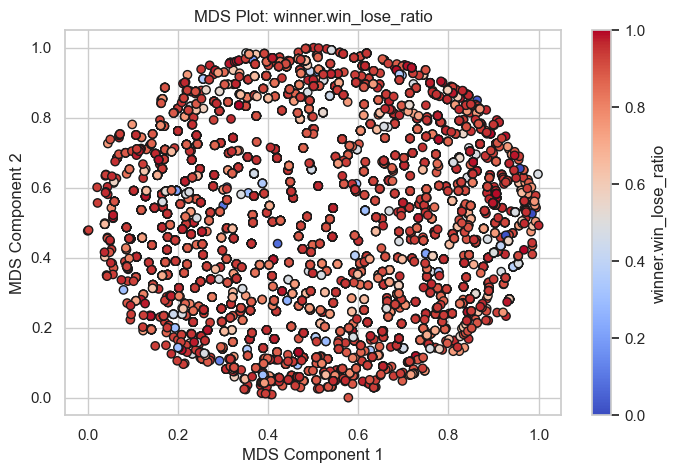

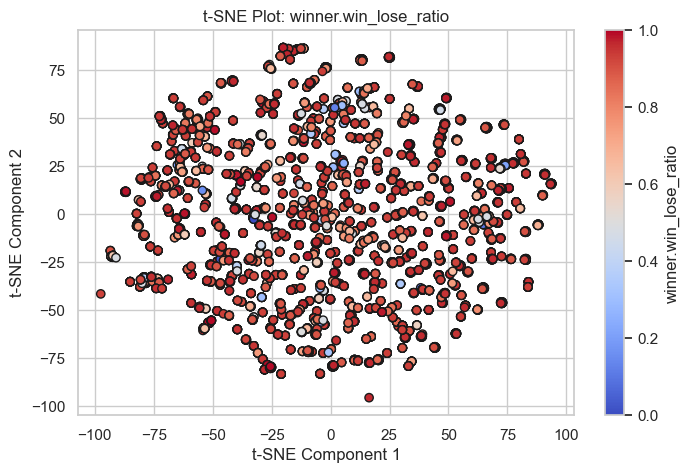

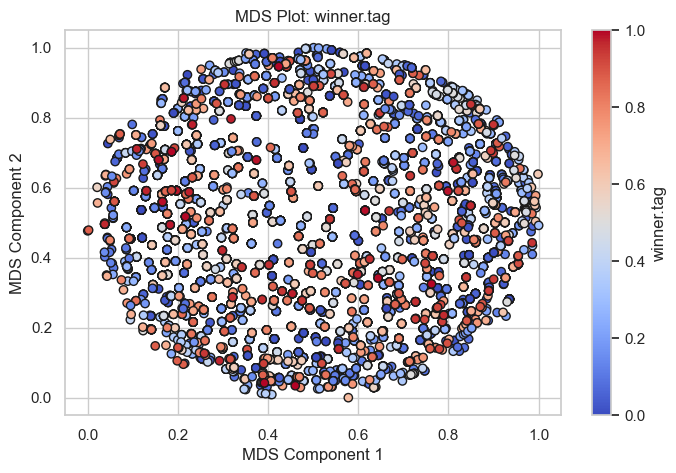

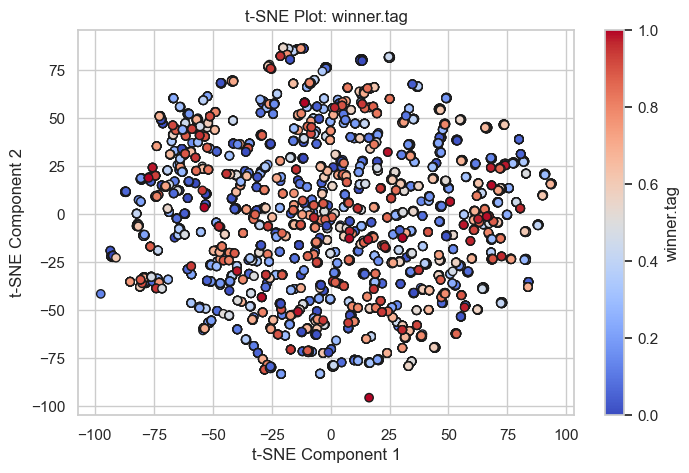

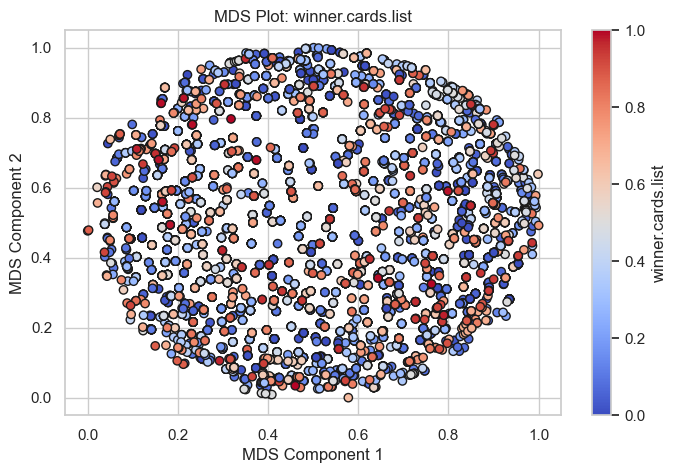

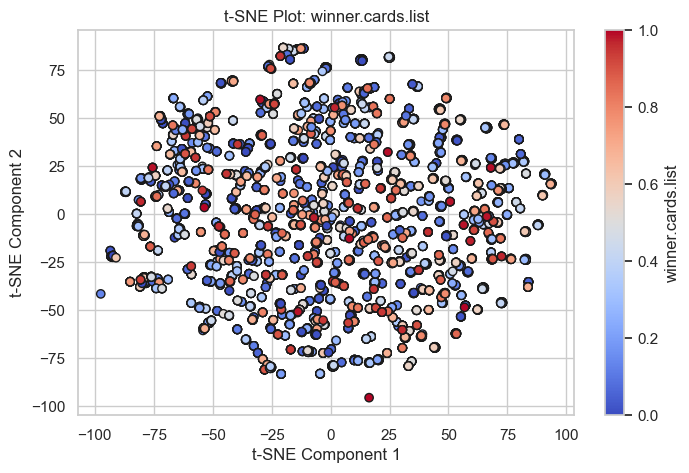

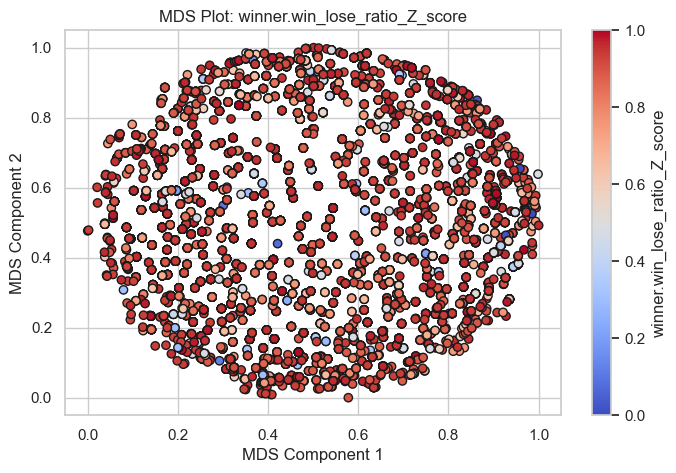

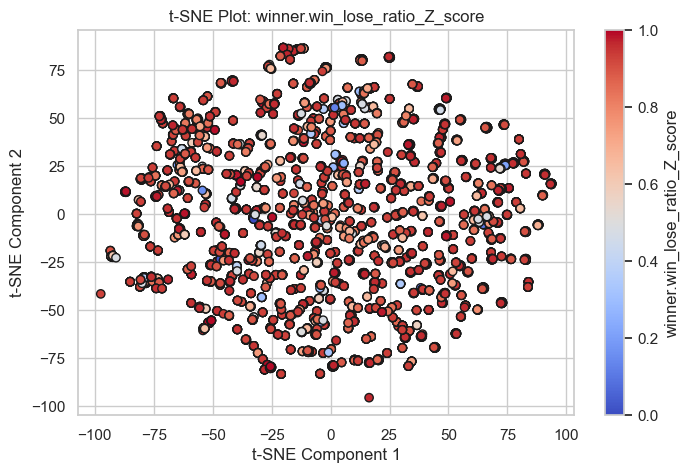

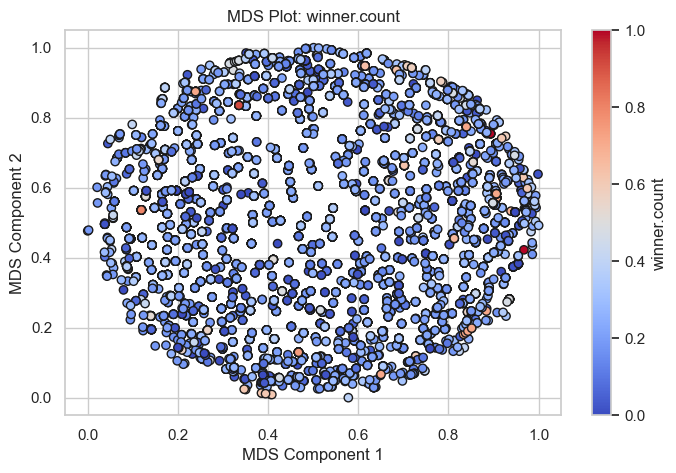

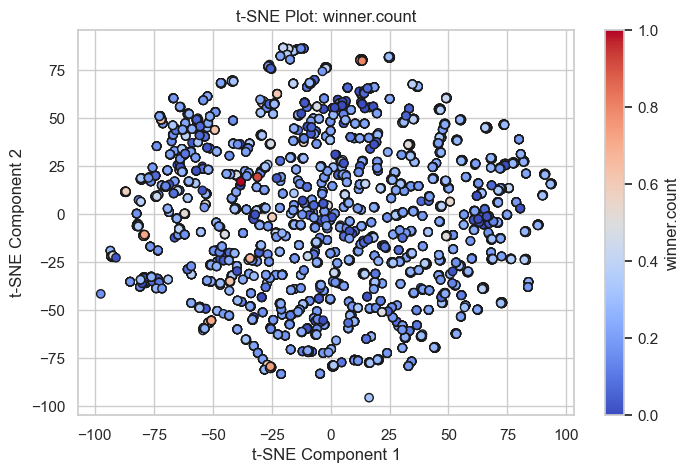

Skipping non-numeric feature: Win Rate


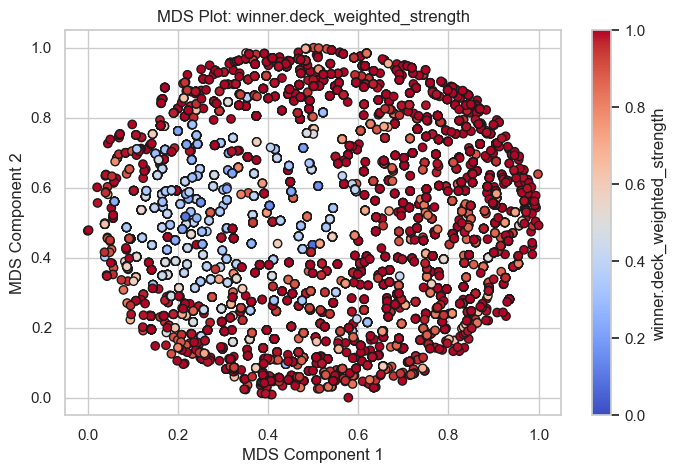

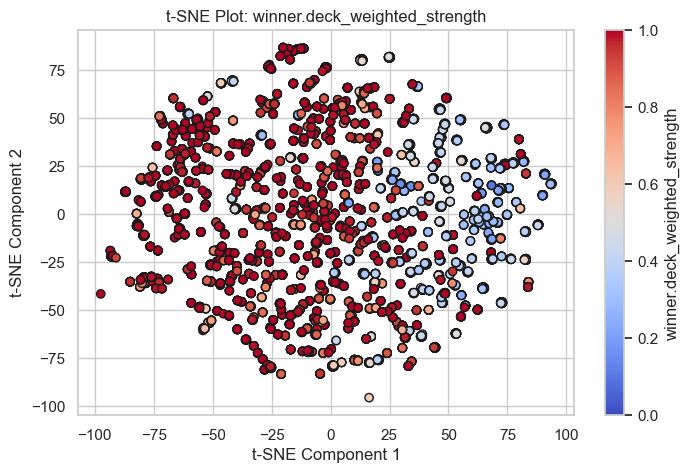

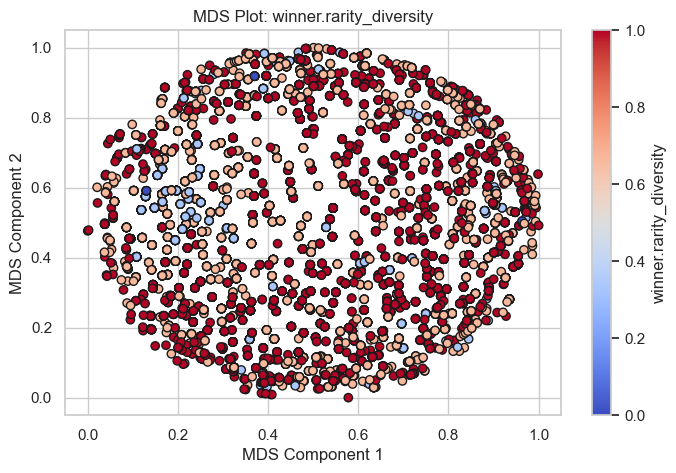

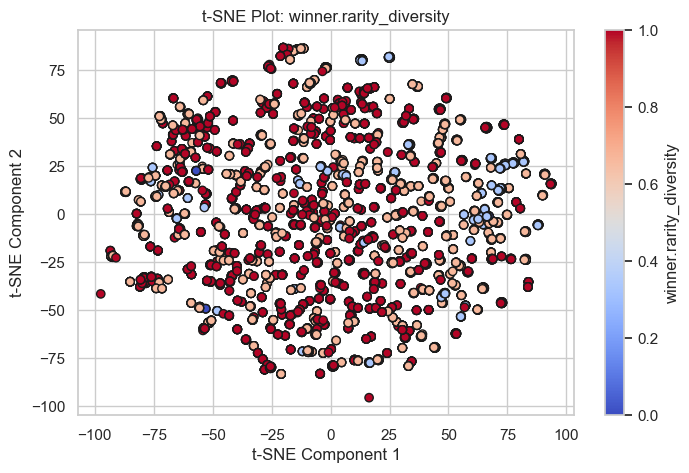

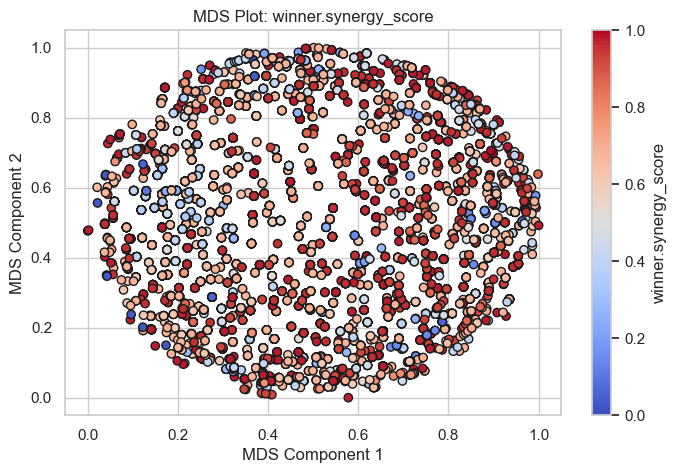

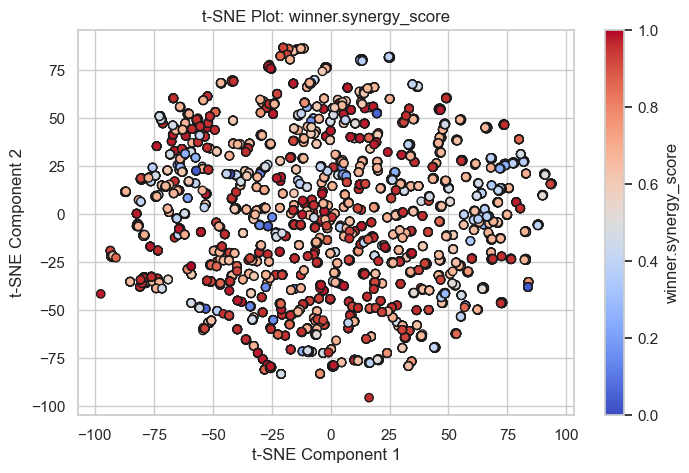

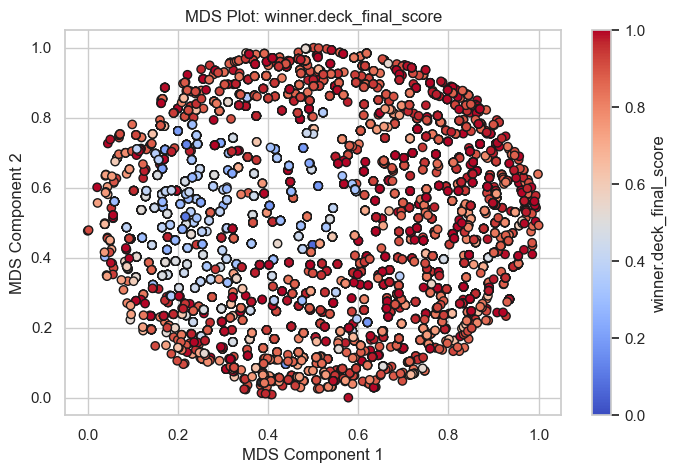

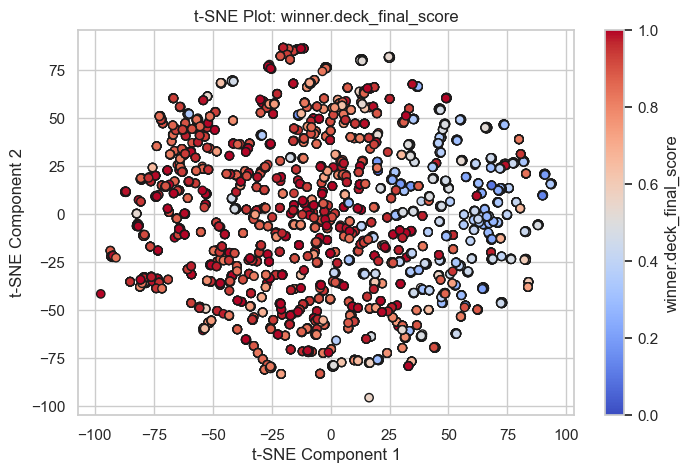

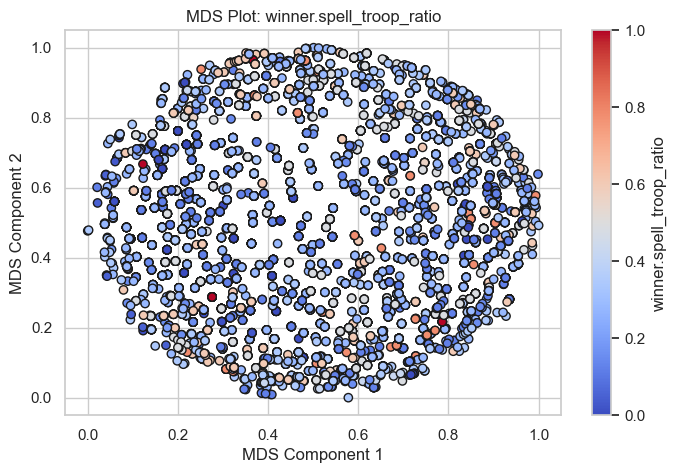

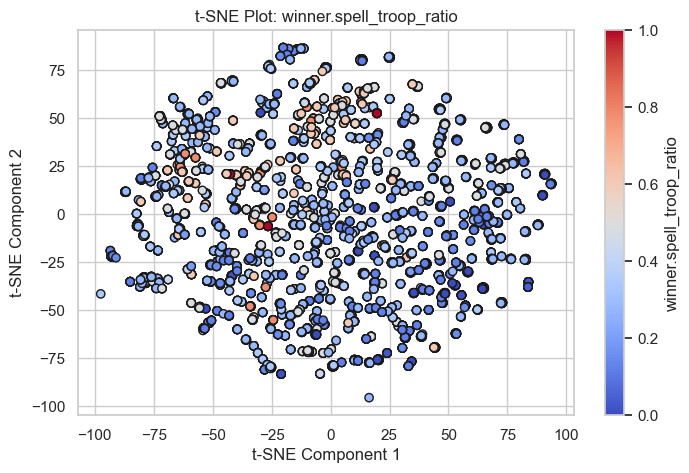

In [32]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

scaler = MinMaxScaler()

for feature in selected_features:
    if pd.api.types.is_numeric_dtype(battles_df_ext[feature]):
        feature_scaled = scaler.fit_transform(battles_df_ext[feature].values.reshape(-1, 1))

        plt.figure(figsize=(8, 5))
        plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                    c=feature_scaled, cmap="coolwarm", edgecolors="k")
        plt.xlabel("MDS Component 1")
        plt.ylabel("MDS Component 2")
        plt.title(f"MDS Plot: {feature}")
        cbar = plt.colorbar()
        cbar.set_label(feature)
        plt.savefig(f"mds_plot_{feature}.png", dpi=300)
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                    c=feature_scaled, cmap="coolwarm", edgecolors="k")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.title(f"t-SNE Plot: {feature}")
        cbar = plt.colorbar()
        cbar.set_label(feature)
        plt.savefig(f"tsne_plot_{feature}.png", dpi=300)
        plt.show()
    else:
        print(f"Skipping non-numeric feature: {feature}")

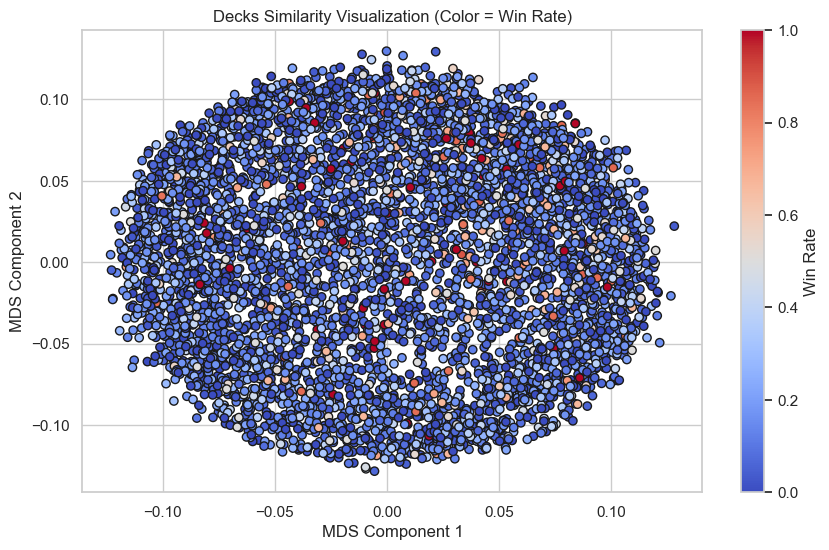

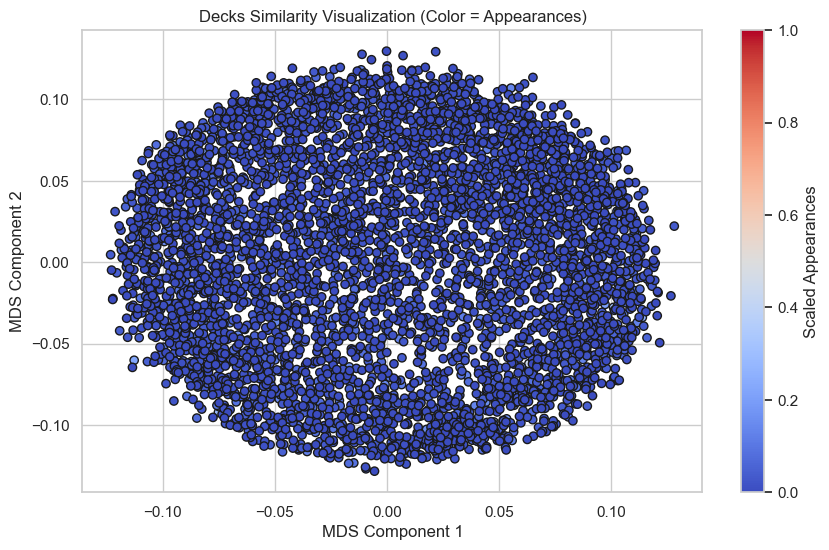

In [ ]:
# color represents win_rate
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                 c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Win Rate")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")
plt.title("Decks Similarity Visualization (Color = Win Rate)")
plt.savefig("deck_similarity_plot_mds.png", dpi=300)
plt.show()

# color represents appearances
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                 c=deck_df["appearance_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Scaled Appearances")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")
plt.title("Decks Similarity Visualization (Color = Appearances)")
plt.savefig("deck_similarity_plot_appearances.png", dpi=300)
plt.show()

In [ ]:
print(deck_df["appearance_scaled"].value_counts().sort_index())

appearance_scaled
0.000000    995
0.003135    603
0.006270    417
0.009404    467
0.012539    279
           ... 
0.473354      1
0.482759      1
0.485893      1
0.507837      1
1.000000      1
Name: count, Length: 93, dtype: int64


# Initial Notes:
1. there doesn't seem to be a correlation between the plot for appearances and the plot for win rate
2. appearances seem to be uniform more or less as most points are colored the same
3. win rate is not as uniform as appearances because we can see more diversity.

In [ ]:

tsne = TSNE(n_components=2, metric="hamming", random_state=42, perplexity=30, n_jobs=-1)
deck_positions_tsne = tsne.fit_transform(deck_vectors_dense)


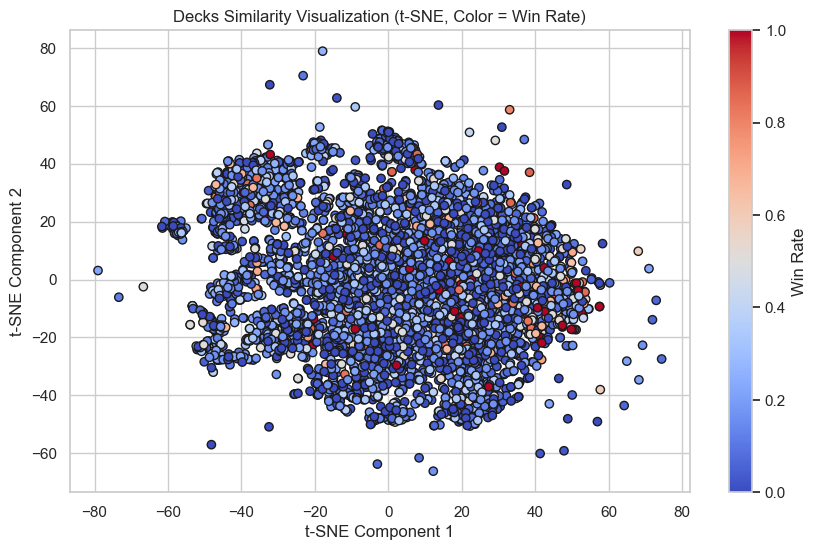

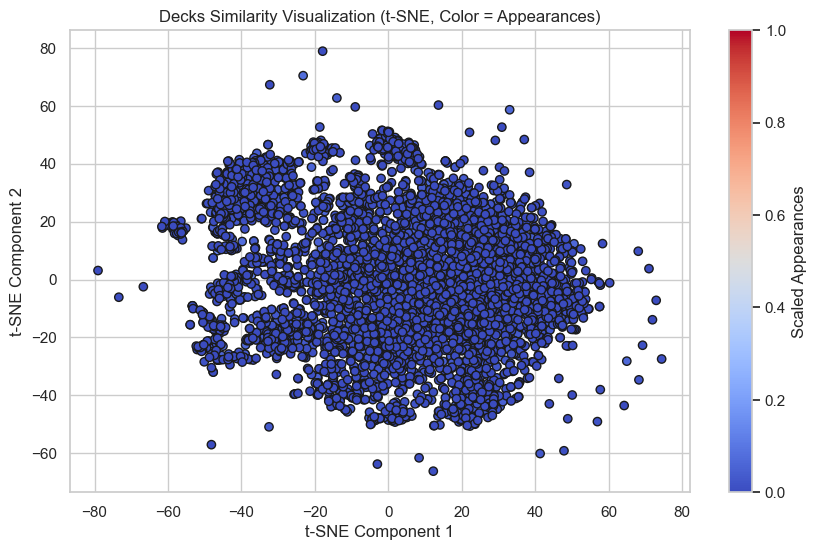

In [ ]:
# color represents win_rate
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                 c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Win Rate")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Decks Similarity Visualization (t-SNE, Color = Win Rate)")
plt.savefig("deck_similarity_plot_tsne_win_rate.png", dpi=300)
plt.show()

# color represents appearances
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                 c=deck_df["appearance_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Scaled Appearances")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Decks Similarity Visualization (t-SNE, Color = Appearances)")
plt.savefig("deck_similarity_plot_tsne_appearances.png", dpi=300)
plt.show()


# Initial thoughts:
1. tsne outcomes seems to be more cramped together than MDS
2. Even though the win rate is still distributed ~uniformly, I can distinguish that at the edges there seems to be clearer red
3. still similar to previously the appearances are still almost uniform

In [ ]:
pairwise_dist_jaccard = squareform(pdist(deck_vectors_dense, metric="jaccard"))

In [ ]:
pairwise_dist_hamming = squareform(pdist(deck_vectors_dense, metric="hamming"))

In [ ]:
pairwise_dist_cosine = squareform(pdist(deck_vectors_dense, metric="cosine"))

# Explanation:
below, we add some plots showing the results we receive for ['hamming', 'jaccard', 'cosine'] metrics to submit which work relatively well for capturing differences / similarities between binary sparse vectors.

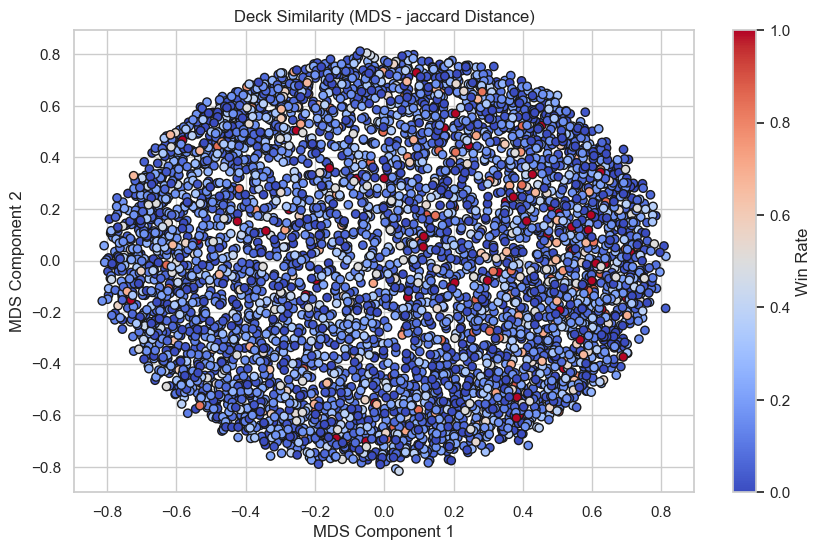

c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


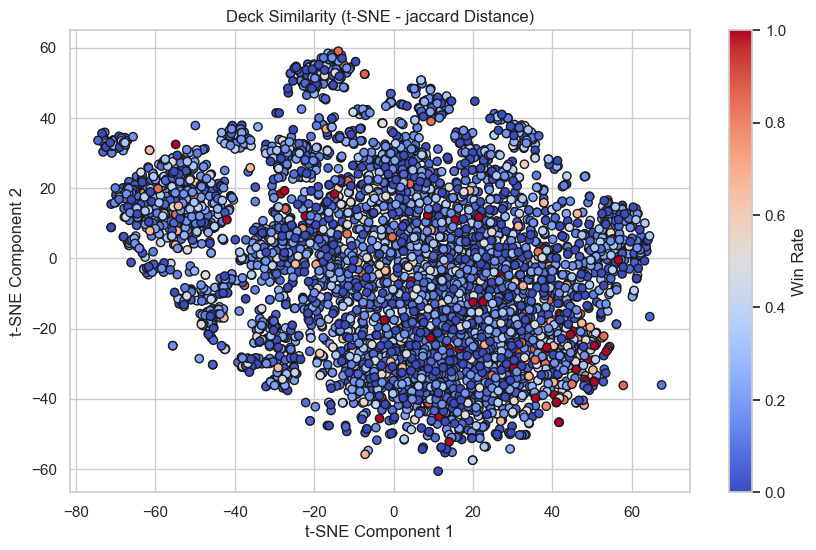

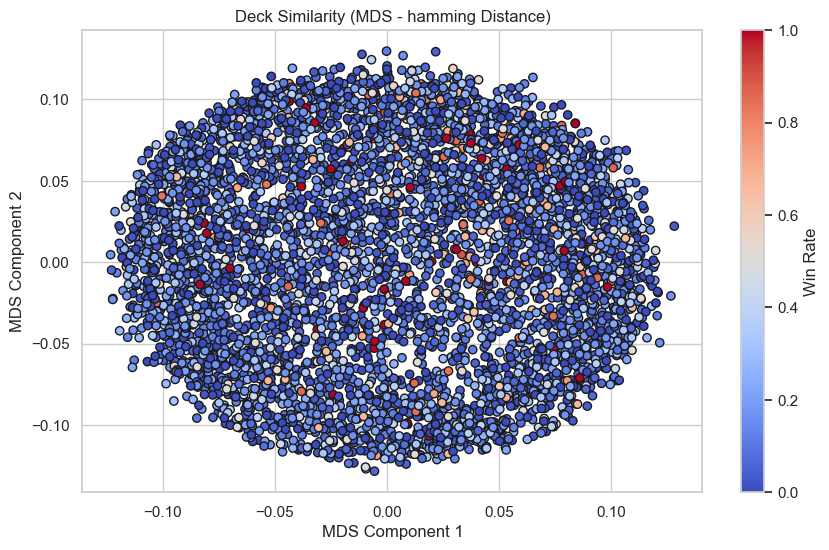

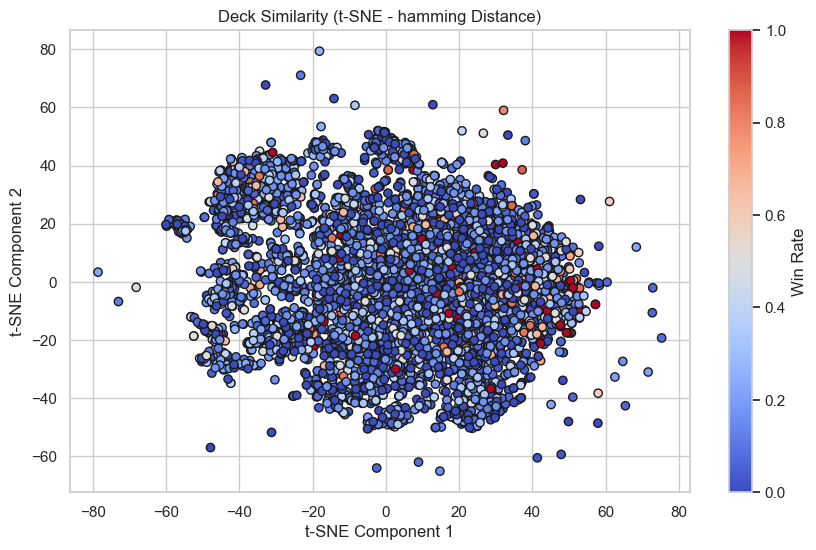

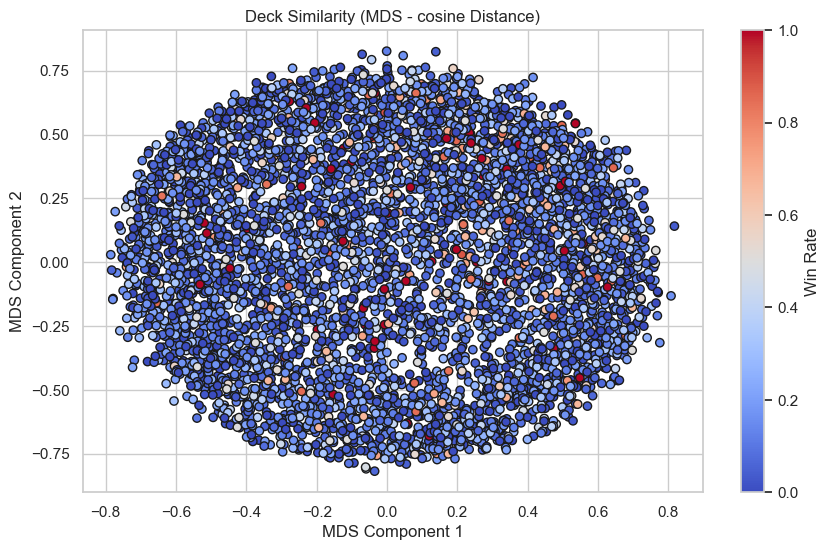

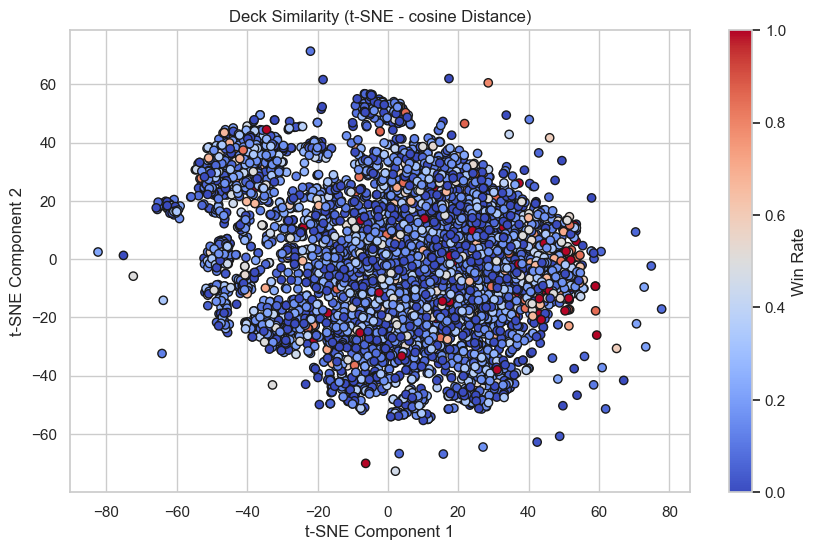

In [ ]:
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import numpy as np

metrics = ["jaccard", "hamming", "cosine"]
plots_mds = {}
plots_tsne = {}

for metric in metrics:
    pairwise_dist_metric = squareform(pdist(deck_vectors_dense, metric=metric))
    
    # ---- MDS Visualization ----
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    deck_positions_mds = mds.fit_transform(pairwise_dist_metric)
    plots_mds[metric] = deck_positions_mds

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                     c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
    cbar = plt.colorbar(sc)
    cbar.set_label("Win Rate")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title(f"Deck Similarity (MDS - {metric} Distance)")
    plt.savefig(f"deck_similarity_mds_{metric}.png", dpi=300)
    plt.show()

    # ---- t-SNE Visualization ----
    tsne = TSNE(n_components=2, metric=metric, random_state=42)
    deck_positions_tsne = tsne.fit_transform(deck_vectors_dense)
    plots_tsne[metric] = deck_positions_tsne

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                     c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
    cbar = plt.colorbar(sc)
    cbar.set_label("Win Rate")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"Deck Similarity (t-SNE - {metric} Distance)")
    plt.savefig(f"deck_similarity_tsne_{metric}.png", dpi=300)
    plt.show()

